## RLDMUU 2025
#### Bandit problems
jakub.tluczek@unine.ch

In [1]:
import random

import numpy as np
from abc import ABC

Let's first define the base class for the stochastic multi-armed bandit. Each of the arm has an underlying gaussian distribution $\mathcal{N}(\mu, \sigma)$, which is unknown in the beginning of the play.

In [2]:
NUM_ARMS = 10
HORIZON = 1000

In [3]:
class Bandit(ABC):
    def __init__(self, arms):
        self.arms = arms

    def pull(self,arm):
        pass

class GaussianBandit(Bandit):
    def __init__(self, arms):
        super().__init__(arms)
        # random mean values, from 0 to 10
        self.means = 10 * np.random.rand(arms)
        # unit variance
        self.stds = np.ones(arms)

    def pull(self, arm):
        return np.random.normal(self.means[arm], self.stds[arm])

In [4]:
bandit = GaussianBandit(NUM_ARMS)

Your task for today is to implement several bandit algorithms explained below. Within the specified time horizon they should learn to find the optimal policy $\pi$. You have to keep track of the results in order to make informed decisions in the future, making sure you balance well between exploration and exploitation. You're also given two benchmark methods - `random_sampling`, which randomly samples the arm to play, as well as `greedy`, which always picks the arm maximizing its Q-value $a = \arg\max_a Q(a)$.

_Hint_: You can update the Q values (mean rewards for a given arm) using this online formula ($N$ signifies the number of times given arm is played):

$$ Q_N(a) = Q_{N-1}(a) + \frac{1}{N} (r_N - Q_{N-1}(a)) $$

### Random sampling

In [5]:
def random(bandit: Bandit, arms: int, horizon: int):
    rewards = np.zeros(horizon)
    for t in range(horizon):
        action = np.random.choice(arms)
        reward = bandit.pull(action)
        rewards[t] = reward
    return rewards

### Greedy

In [6]:
def greedy(bandit: Bandit, arms: int, horizon: int):
    Q = np.zeros(arms)
    N = np.zeros(arms)
    rewards = np.zeros(horizon)
    for t in range(horizon):
        action = np.argmax(Q)
        reward = bandit.pull(action)
        rewards[t] = reward
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
    return rewards

### $\epsilon$-greedy

Modus operandi of $\epsilon$-greedy algorithm is very simple. Every iteration you sample a random number from range $[0,1]$. If said value is bigger than $\epsilon$, which also should lie in the same interval, then we pick the action $a = \arg\max_a Q(a)$. Otherwise, action is sampled from the action set $a \sim A$.

In [17]:
import random as rdm
def egreedy(bandit: Bandit, arms: int, horizon: int, epsilon: float):
    Q = np.zeros(arms)
    N = np.zeros(arms)
    rewards = np.zeros(horizon)
    for t in range(horizon):
        if rdm.uniform(0,1) > epsilon:
            action = np.argmax(Q)
        else: 
            action = np.random.choice(arms)
        reward = bandit.pull(action)
        rewards[t] = reward
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
    return rewards

### Upper confidence bound (UBC)

UBC is a different algorithm where each action is picked using the following formula:

$$ a_t = \arg\max_a \left[ Q_t(a) + c \sqrt{\frac{\ln t}{N_t(a)}} \right]$$

where $t$ stands for a specific timestep, $N_t(a)$  is the number of times this specific action had been played, and $c$ is a constant that incentivizes exploration. If $c=0$, then we just have greedy algorithm, while higher values of $c$ put more emphasis on exploring actions that had been played least amount of times.

_Hint_: Remember to handle possible zero-division in the beginning, when $\forall_a N_t(a) = 0$.

In [13]:
def ucb(bandit: Bandit, arms: int, horizon: int, c: float):
    Q = np.zeros(arms)
    N = np.zeros(arms)
    rewards = np.zeros(horizon)
    for t in range(horizon):
        if np.any(N == 0):
            action = np.random.choice(np.where(N == 0)[0])
        else:
            action = np.argmax(Q + c*(np.log(t)/N))
        reward = bandit.pull(action)
        rewards[t] = reward
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
    return rewards

### Thompson sampling

Thompson sampling is the last algorithm that you are going to implement today. Basic idea behind it is, that we sample a parameter from the posterior distribution, and we choose the action that maximizes the expected reward given these parameters. In the case of Gaussian bandits, we would like to estimate the mean $\mu$ of each arm, which is unknown in the beginning. Thompson sampling achieves that in several steps:

- Assume we know the $\sigma_k$, which in our case is equal to 1 for all arms $k$
- Also assume the normal prior distribution for mean estimate of each arm (We say, that conjugate prior is also normal). In our case, since we know that means can range from 0 to 10, $\tilde{\mu}_k \sim \mathcal{N}(5, 1)$, with $\hat{\mu}_k = 5$ and $\hat{\sigma}_k = 1$
- Now estimate a mean for each arm, by sampling from corresponding distributions, defined in previous point
- Pick the arm with the biggest sampled mean $a = \arg\max_k \tilde{\mu}_k$, and observe reward, which follows the distribution $r \sim \mathcal{N}(\mu_k, \sigma_k)$ (Recall that $\sigma_k$ is known, $\mu_k$ is not)
- Update the posterior estimates, using following formulas:

$$ \hat{\mu}_k' = \mathbb{E}(\hat{\mu}_k' | r) = \frac{\hat{\sigma}_k^2 r + \sigma_k^2 \hat{\mu}_k}{\hat{\sigma}_k^2 + \sigma_k^2} $$ 
$$ \hat{\sigma}_k' = \sqrt{\text{Var}(\hat{\mu}_k | r)} = \sqrt{\frac{\hat{\sigma}_k^2 \sigma_k^2}{\hat{\sigma}_k^2 + \sigma_k^2}}$$

- Assign new estimates, i.e. $\hat{\mu}_k = \hat{\mu}_k'$, $\hat{\sigma}_k = \hat{\sigma}_k'$
- Rinse and repeat

While the update formulas might seem intimidating, Thompson sampling follows a simple flow once you exchange the math formulas into programming variables. If you still feel unfamiliar with the idea, go ahead and do the bonus exercise, where posterior updates are much easier to digest.

In [9]:
dist = [np.random.normal(loc=5,scale=1) for i in range(NUM_ARMS)]

In [10]:
dist[0]

3.513774793234486

In [15]:
def gaussian_thompson_sampling(bandit: GaussianBandit, arms: int, horizon: int, initial_mean_estimate: int = 5, true_std: int = 1):
    Q = np.zeros(arms)
    N = np.zeros(arms)
    mu = np.ones(arms)*initial_mean_estimate
    sigma = np.ones(arms)*true_std
    rewards = np.zeros(horizon)
    for t in range(horizon):
        dist = [np.random.normal(loc=mu[i],scale=sigma[i]) for i in range(NUM_ARMS)]
        action = np.argmax(dist)
        reward = bandit.pull(action)
        rewards[t] = reward
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        mu[action] = (sigma[action]**2 * reward + true_std**2 * mu[action])/(sigma[action]**2 + true_std**2)
        sigma[action] = np.sqrt((sigma[action]**2 * true_std**2)/(sigma[action]**2 + true_std**2))
    return rewards

### Comparison

Plot the rolling average of rewards (with the rolling window of your choice) for all the algorithms you implemented and compare their performance.

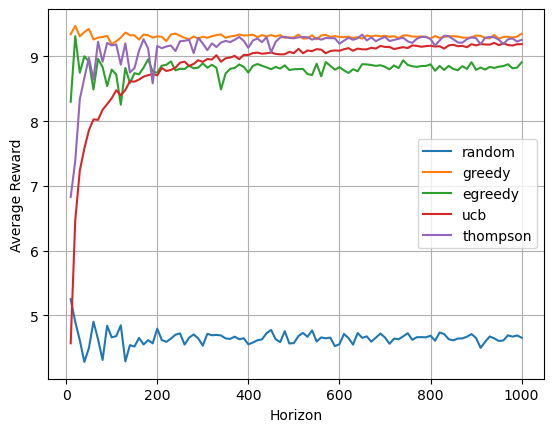

In [46]:
import numpy as np
import matplotlib.pyplot as plt

avg_random = []
avg_greedy = []
avg_egreedy = []
avg_ucb = []
avg_thompson = []

horizon_values = np.linspace(10, HORIZON, 100)

for horizon in horizon_values:
    horizon = int(horizon)
    rewards_random = np.zeros(horizon)
    rewards_greedy = np.zeros(horizon)
    rewards_egreedy = np.zeros(horizon)
    rewards_ucb = np.zeros(horizon)
    rewards_thompson = np.zeros(horizon)
    repeat = 5
    for i in range(repeat):  # 5 runs
        rewards_random += random(bandit, NUM_ARMS, horizon) / repeat
        rewards_greedy += greedy(bandit, NUM_ARMS, horizon) / repeat
        rewards_egreedy += egreedy(bandit, NUM_ARMS, horizon, 0.1) / repeat
        rewards_ucb += ucb(bandit, NUM_ARMS, horizon, 2) / repeat
        rewards_thompson += gaussian_thompson_sampling(bandit, NUM_ARMS, horizon) / repeat
    
    avg_random.append(np.mean(rewards_random))
    avg_greedy.append(np.mean(rewards_greedy))
    avg_egreedy.append(np.mean(rewards_egreedy))
    avg_ucb.append(np.mean(rewards_ucb))
    avg_thompson.append(np.mean(rewards_thompson))

plt.plot(horizon_values, avg_random, label='random')
plt.plot(horizon_values, avg_greedy, label='greedy')
plt.plot(horizon_values, avg_egreedy, label='egreedy')
plt.plot(horizon_values, avg_ucb, label='ucb')
plt.plot(horizon_values, avg_thompson, label='thompson')

plt.xlabel('Horizon')
plt.ylabel('Average Reward')
plt.legend()
plt.grid(True)
plt.show()

### BONUS: Thompson sampling with bernoulli bandits

Posterior updates are simpler when we consider bandits, which output binary rewards following the bernoulli distributions - i.e., each time an arm is pulled, bandit outputs a success or failure, that is reward of 0 or 1. In this case, its conjugate prior is a Beta distribution. Convieniently, $\text{Beta}(\alpha, \beta)$ has two parameters, which can be thought of successes and failures. That is, when we pull an arm and succeed, we increase $\alpha$ by 1, if we fail, we increase $\beta$ by 1. This is because $\mathbb{E} \left[ \text{Beta}(\alpha, \beta) \right] = \frac{\alpha}{\alpha + \beta}$. Moreover, initial parameters $\alpha = 1, \beta = 1$ result in a uniform distribution, making each arm being equally as likely to be chosen.

First implement the `BernoulliBandit` in a similar fashion we did with `GaussianBandit`:

In [70]:
class BernoulliBandit(Bandit):
    def __init__(self, arms):
        super().__init__(arms)
        self.prob = np.random.rand(arms)
        self.best_arm = np.max(self.prob)

    def pull(self, arm):
        return np.random.rand() <self.prob[arm]
    
bandit = BernoulliBandit(NUM_ARMS)

Following the similar flow as with gaussian bandits:

- Initialize prior with $\tilde{\mu}_k \sim \text{Beta}(\alpha_k, \beta_k)$, and $\alpha_k = 1, \beta_k = 1$
- Sample $\tilde{\mu}_k$ and choose the action $a = \arg\max_k \tilde{\mu}_k$
- Observe reward $r \sim \text{Bern}(\mu_k)$
- If $r = 1$, $\alpha_k' = \alpha_k + 1$ 
- If $r = 0$, $\beta_k' = \beta_k + 1$

In [71]:
def bernoulli_thompson_sampling(bandit: BernoulliBandit, arms: int, horizon: int):
    Q = np.zeros(arms)
    N = np.zeros(arms)
    alpha = np.ones(arms)
    beta = np.ones(arms)
    rewards = np.zeros(horizon)
    for t in range(horizon):
        dist = [np.random.beta(alpha[i], beta[i]) for i in range(NUM_ARMS)]
        action = np.argmax(dist)
        reward = bandit.pull(action)
        rewards[t] = reward
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        if reward == 1:
            alpha[action] += 1
        else:
            beta[action] += 1
    return rewards

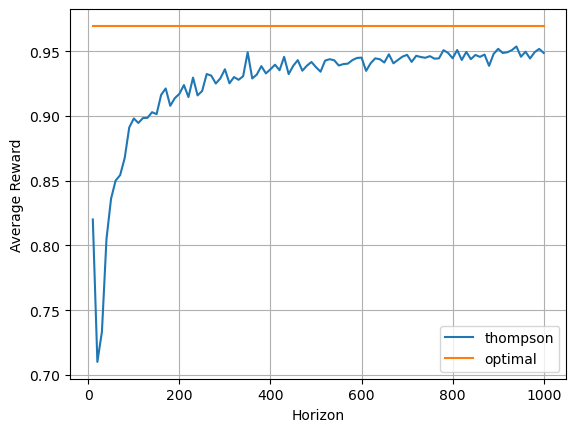

In [73]:
import numpy as np
import matplotlib.pyplot as plt

avg_random = []
avg_greedy = []
avg_egreedy = []
avg_ucb = []
avg_thompson = []

horizon_values = np.linspace(10, HORIZON, 100)
for horizon in horizon_values:
    horizon = int(horizon)
    rewards_thompson = np.zeros(horizon)
    repeat = 5
    for i in range(repeat):  # 5 runs
        rewards_thompson += bernoulli_thompson_sampling(bandit, NUM_ARMS, horizon) / repeat
    avg_thompson.append(np.mean(rewards_thompson))

plt.plot(horizon_values, avg_thompson, label='thompson')
plt.plot(horizon_values,bandit.best_arm*np.ones(100), label='optimal')
plt.xlabel('Horizon')
plt.ylabel('Average Reward')
plt.legend()
plt.grid(True)
plt.show()